In [1]:
from ocean_navigation_simulator.utils.misc import get_c3
import os
%load_ext autoreload
%autoreload 2

In [2]:
c3 = get_c3()

Starting to connect to c3


In [3]:
experiment_name = "multi_ag_30_HC_HC"
exp = c3.Experiment.get(experiment_name)
exp
#exp.remove()

# Set up the experiments

In [4]:
timeout_sim_h = 6*24 # 6 days

In [5]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 0.5,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "data/miss_gen_hindcast/",
                "local": False,
                "source": "HYCOM",
                "type": "hindcast",
                "currents": "total",
                "region": "GOM",
            },
        },
        "forecast": None, #{
        #     "field": "OceanCurrents",
        #     "source": "forecast_files",
        #     "source_settings": {
        #         "folder": "data/miss_gen_forecast/",
        #         "local": False,
        #         "source": "Copernicus",
        #         "type": "forecast",
        #         "currents": "total",
        #         "region": "GOM"
        #     },
        # },
    },
    "multi_agent_constraints": {
        "unit": "km",
        "communication_thrsld": 9,
        "epsilon_margin": 1,  # when add edges based on hysteresis
        "collision_thrsld": 0.2,
    },
}
objectiveConfig = {'type': "nav"}

In [6]:
# create Experiment
exp = c3.Experiment.createNew(
    name = experiment_name,
    description = "multi agent",
    arenaConfig = arena_config,
    objectiveConfig= objectiveConfig,
    timeout_in_sec=3600*timeout_sim_h, 
)

# Set up generate batch job

## Set up and run mission generation

In [ ]:
import datetime
missGenBatchConfig = {
    ##### Target Sampling #####
    # HYCOM HC: lon [-98.0,-76.4000244140625], lat[18.1200008392334,31.92000007629394]
    # Copernicus FC: lon: [-98.0, -76.416664], lat: [18.083334, 30.0]
    # Combined: [-98.0, -76.416664], [18.1200008392334, 30.0]
    "x_range": [-96, -78],
    "y_range": [20, 29],
    # "x_range": [-160, -105],
    # "y_range": [15, 40],
    "t_range": [  # ['2022-08-01T00:00:00+00:00', '2022-08-30T00:00:00+00:00'],
        # Copernicus FC: 2022-04 until today, HYCOM Hindcast: 2021-09 until today
        datetime.datetime(year=2022, month=4, day=1, tzinfo=datetime.timezone.utc),
        datetime.datetime(year=2022, month=12, day=30, tzinfo=datetime.timezone.utc),
    ],
    "problem_timeout_in_h": timeout_sim_h, #to be considered as feasible
    "target_distance_from_land": 1.2,
    "problem_target_radius": 0.25,
    ##### HJ Planner #####
    "hj_specific_settings": {
        # 'grid_res' has to be smaller than target_radius to prevent hj_solver errors
        "grid_res": 0.02,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "direction": "multi-time-reach-back",
        "n_time_vector": 199,  # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "run_without_x_T": True,
        "progress_bar": False,
        "T_goal_in_seconds": 3600 * 24 * 7, #7 days here #
    },
    "hj_planner_box": 2.0,
    ##### Start Sampling #####
    "feasible_missions_per_target": 2,
    "random_missions_per_target": 0,
    "multi_agent": {
        "is_multi_agent": True,
        "nb_platforms": 30,
        "minimum_dist_km": 2,
        "sampling_range_radius_km": 60,
        "sample_range_ttr_h": [72, 132], # this has to be a larger than the "feasible_mission_time_in_h"
        # as the multi-agent points are sampled from "feasible_mission_time_in_h" with added noise which might 
        # increase their ttr by quite a lot (so either this interval has to be increased or the other reduced)
    },
    "min_distance_from_hj_frame": 0.75,
    "min_distance_from_land": 0.4,
    "feasible_mission_time_in_h": [96, 104],
    "random_min_distance_from_target": 0.5,
    ##### Actions #####
    "plot_batch": False,
    "animate_batch": False,
    "cache_forecast": False,
    "cache_hindcast": False,
}

In [ ]:
options = c3.GenMissionBatchJobOptionsNicolas(**{
    'experiment':exp,
    'missGenBatchConfig': missGenBatchConfig,
    'base_seed': 1,
    'nBatches': 140, # each nBatch runs nMissionsGenPerBatch, how many cores we spin up so faster to make this big compared to nMissionGenPerBatch
    'nMissionGenPerBatch': 8, #nb workers on which we loop,
    #'hardwareProfileId': "appc8m64-w"
})
#total amount of missions: feasible_mission_per_target*nBatches*nMIssionGenPerBatch

#### Debug locally

In [ ]:
import random
from ocean_navigation_simulator.reinforcement_learning.missions.MissionGenerator import (
    MissionGenerator,
)
config = missGenBatchConfig
config_to_add = {
    "scenario_config": arena_config,
  "problem_timeout": datetime.timedelta(
         seconds=exp.get("timeout_in_sec").timeout_in_sec
    ),
 "T_goal_in_seconds": exp.get("timeout_in_sec").timeout_in_sec,
}

config = config | config_to_add
random.seed(options.base_seed)
results_folder = "/tmp/missions/"
os.makedirs(results_folder, exist_ok=True)
# seed all of them
all_problems_c3 = []
for worker in range(2):
    mission_generator = MissionGenerator(
        config=config
        | {
            "seed": int(random.uniform(0, 1000000)),
            "cache_folder": results_folder + str(worker) + "_",
        },
        c3=c3,
    )
    problems_c3, _, _ = mission_generator.cache_batch()
    all_problems_c3.extend(problems_c3)

In [ ]:
# Now upload all of them to the mission database!
exp = options.experiment
for idx, problem in enumerate(all_problems_c3):
    exp.addMission(
        missionConfig=problem.to_c3_mission_config(),
        name="batch_seed_" + str(options.base_seed) + "_" + str(idx),
    )
exp.get('expMissions').expMissions

In [ ]:
problems_c3[0]

In [ ]:
problems_c3[0].extra_info

#### Start Jobs

In [ ]:
gen_mission_job = c3.GenMissionBatchJobNicolas(**{'options': options.toJson()}).upsert()
#gen_mission_job = c3.GenMissionBatchJob(**{'options': options.toJson()}).upsert()
# gen_mission_job.setMaxConcurrency(12)
# gen_mission_job.setMaxConcurrencyPerNode(15)
gen_mission_job.start()
gen_mission_job

In [ ]:
#gen_mission_job = c3.GenMissionBatchJobNicolas.get('15140b6a-ba11-4fff-836c-f95fefe6ab2e')
gen_mission_job.status()

In [ ]:
gen_mission_job.computingActions()
#gen_mission_job.cancel()

In [ ]:
len(exp.get('expMissions').expMissions)

#### Tools to run after missionGeneration/debug

In [ ]:
filter = 'options.id'#+ '"' + exp.id + '"'
#objs_list = c3.GenMissionBatchJobNicolas.fetch(spec={'include': "[this]", 'filter':filter}).objs
objs_list = c3.GenMissionBatchJobNicolas.fetch(spec={'include': "[this]"}).objs
for obj in objs_list:
    if obj.get("options").options.experiment.id!=exp.id:
        objs_list.remove(obj)
print("Total of {} BatchJobNicolas".format(len(objs_list)))

staged_to_run = 0
running_job = 0
completed_job = 0
canceled_job = 0

for job in objs_list:
    if job.get("BatchJobStatus").status().status == "initial":
        staged_to_run += 1
    elif job.get("BatchJobStatus").status().status == "running":
        running_job += 1
    elif job.get("BatchJobStatus").status().status == "completed":
        completed_job += 1 
    elif job.get("BatchJobStatus").status().status == "canceled":
        canceled_job += 1

print("staged_to_run: ", staged_to_run)
print("running_job ", running_job)
print("completed_job: ", completed_job)
print("canceled_job: ", canceled_job)

In [ ]:
objs_list[0]

In [ ]:
gen_mission_job.cancel() # to cancel the jobs of this specific gen_batch

In [ ]:
#Other Utils for the cluster
c3.Cluster.actionDump()

+ Inspect a specific mission

In [ ]:
exp.get('expMissions').expMissions[0].get('missionConfig').missionConfig

#### Cancel or remove jobs on c3 that are still runing or pending

In [ ]:
status = ' && status ==' + '"' + 'running' + '"'
all_gen_mission_jobs=c3.GenMissionBatchJobNicolas.fetch(spec={'include': "[this]",              
                                         }
                                   ).objs

In [ ]:
for job in all_gen_mission_jobs:
    if job.get("BatchJobStatus").status().status == "running":
        print(job.get("BatchJobStatus").status().status)
        job.cancel()

    elif job.get("BatchJobStatus").status().status =="initial":
        print(job.get("BatchJobStatus").status().status)
        job.remove()
    #print(job.get("BatchJobStatus").status().status)

## Plot all of them on a map and get distribution information

In [ ]:
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
from ocean_navigation_simulator.environment.PlatformState import (
    PlatformState,
    PlatformStateSet,
    SpatialPoint,
)

from ocean_navigation_simulator.utils import units

problems = []
for miss in exp.get('expMissions').expMissions:
    missionConfig = miss.get("missionConfig").missionConfig
    problems.append(CachedNavigationProblem.from_c3_mission_config(missionConfig))

+ Save missions as CSV file

In [ ]:
import pandas as pd
filename_to_save = "problemsGOM_30pltf.csv"
results_folder = f"{os.getcwd()}/generated_media/generated_problems/"
os.makedirs(results_folder, exist_ok=True)
df = pd.DataFrame([problem.to_dict() for problem in problems])
df['factory_index'] = 0
df.to_csv(results_folder + filename_to_save)


In [ ]:
from scripts.nicolas.scripts_for_exp_runs.c3_multi_ag.utils_scripts import plot_missions_target_cartopy
plot_missions_target_cartopy(df=df, region="GOM")

In [ ]:
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner)
GenerationRunner.plot_ttr_histogram(results_folder)
# GenerationRunner.plot_starts_and_targets(
#     results_folder=results_folder, pb_filename="problemsGOM_1000.csv", scenario_config=arena_config,
# )


# Load from existing CSV files of Missions

In [7]:
from ast import literal_eval
import pandas as pd
from ocean_navigation_simulator.reinforcement_learning.missions.CachedNavigationProblem import (
    CachedNavigationProblem,
)
filename_pb = "problemsGOM_30pltf.csv" #"problemsGOM_550.csv"
path_to_problems = os.path.join(os.getcwd(), "generated_media/generated_problems/")
problems_df = pd.read_csv(path_to_problems + filename_pb)

### Visualize problems

/home/nicolas/documents/Master_Thesis_repo/OceanPlatformControl/scripts/nicolas/scripts_for_exp_runs/c3_multi_ag/utils_scripts.py:38: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



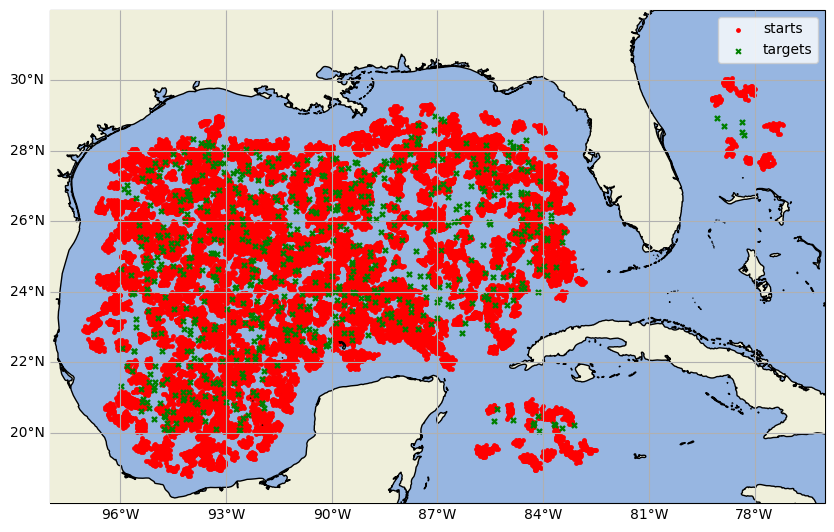

In [8]:
from scripts.nicolas.scripts_for_exp_runs.c3_multi_ag.utils_scripts import plot_missions_target_cartopy
missions_to_dwnld = range(1200) #range(len(problems_df))
problem_list=[CachedNavigationProblem.from_pandas_row(problems_df.iloc[idx]) for idx in missions_to_dwnld]
df = pd.DataFrame([problem.to_dict() for problem in problem_list])
plot_missions_target_cartopy(df=df, region="GOM")

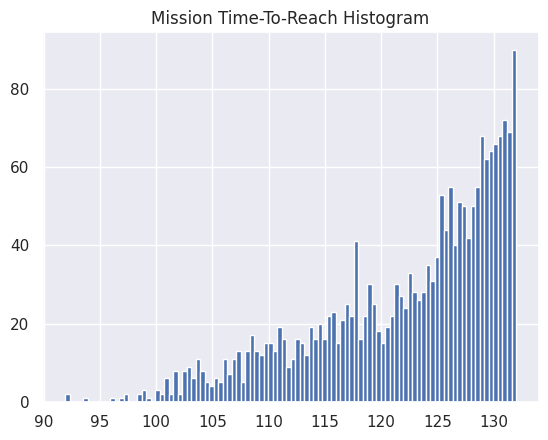

In [9]:
from ocean_navigation_simulator.reinforcement_learning.runners.GenerationRunner import (
    GenerationRunner)
results_folder = f"{os.getcwd()}/generated_media/generated_problems/"
GenerationRunner.plot_ttr_histogram(results_folder, pb_filename=filename_pb )
# GenerationRunner.plot_starts_and_targets(
#     results_folder=path_to_problems, pb_filename=filename_pb, scenario_config=arena_config,
# )

## Make sure to create/select a new experiment where you want to add the retrieved missions to

In [ ]:
# experiment_name = "m_a_gom"
# exp = c3.Experiment.get(experiment_name)
# #exp.remove()

In [10]:
exp

c3.Experiment(
 id='multi_ag_30_HC_HC',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 23, 51, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 23, 51, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 23, 51, tzinfo=datetime.timezone.utc)),
 version=1,
 T_horizon_FC_Error_Calculation_in_h=96)

In [11]:
for idx_mission in missions_to_dwnld:
    problem=CachedNavigationProblem.from_pandas_row(problems_df.iloc[idx_mission])
    exp.addMission(problem.to_c3_mission_config())

In [12]:
len(exp.get('expMissions').expMissions)

1200

# Add Observer

In [13]:
# Config for No observer
observer_config = {"observer": None}
# add observer
exp.addObserver(name="NoObserver", observerConfig=observer_config)

c3.ObserverSetting(
 id='multi_ag_30_HC_HC_NoObserver',
 name='NoObserver',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 30, 2, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 30, 2, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 30, 2, tzinfo=datetime.timezone.utc)),
 version=1)

# Add Controller

In [14]:
# Controller Configs
HJMultiTimeConfig = {
    "replan_every_X_seconds": None,
    "replan_on_new_fmrc": True,
    "T_goal_in_seconds": 3600 * 24 * 6,  # 3d, 43200,     # 12h
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner",
    "d_max": 0.0,
    "deg_around_xt_xT_box": 1.0,
    "direction": "multi-time-reach-back",
    "grid_res": 0.02,
    "n_time_vector": 200,
    "progress_bar": True,
    "use_geographic_coordinate_system": True,
}
StraightLineConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.NaiveController.NaiveController"
}
flockingConfig = {
    "unit": "km",
    "interaction_range": 9,  # km
    "grad_clip_range": 0.1,  # km
}
reactiveConfig = {
    "unit": "m",
    "mix_ttr_and_euclidean": False,
    "delta_3": 8800,  # collision threshold (communication - delta_3)
    "delta_2": 2000,  # safe zone threshold  ]communication - delta_2, communication - delta_3[
    "delta_1": 500,  # small threshold so that if distance > communication_thrsld- delta_1 we try to achieve connectivity
    "communication_thrsld": 9000,
    "k_1": 0.25,
    "k_2": 1,
}
multiAgentOptimConfig = {
    "unit": "m",
    "interaction_range": 9000,  # m
    "optim_horizon": 6,  # 1h
    "scaling_pot_function": 10,
}

#### Add HJ Naive controller

In [15]:
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "hj_naive",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
}

In [16]:
exp.experimentName = exp.get('experiment_name')
# add controller
exp.addController(name='hj_naive', ctrlConfig=MultiAgentCtrlConfig)

c3.ControllerSetting(
 id='multi_ag_30_HC_HC_hj_naive',
 name='hj_naive',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 30, 21, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 30, 21, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 30, 21, tzinfo=datetime.timezone.utc)),
 version=1)

#### Add Reactive Controller

In [17]:
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "reactive_control",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "reactive_control_config": reactiveConfig,
}

In [18]:
exp.experimentName = exp.get('experiment_name')
# add controller
exp.addController(name='reactive_ctrl', ctrlConfig=MultiAgentCtrlConfig)

c3.ControllerSetting(
 id='multi_ag_30_HC_HC_reactive_ctrl',
 name='reactive_ctrl',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 30, 29, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 30, 29, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 30, 29, tzinfo=datetime.timezone.utc)),
 version=1)

#### Add Flocking Controller

In [19]:
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "flocking",  # choose from hj_naive, flocking, reactive_control
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "flocking_config": flockingConfig,
}

In [20]:
exp.experimentName = exp.get('experiment_name')
exp.addController(name='flocking', ctrlConfig=MultiAgentCtrlConfig)

c3.ControllerSetting(
 id='multi_ag_30_HC_HC_flocking',
 name='flocking',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 30, 39, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 30, 39, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 30, 39, tzinfo=datetime.timezone.utc)),
 version=1)

### Add Multi Agent Optimizer over full HJ trajectory

In [ ]:
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "multi_ag_optimizer",  # choose from hj_naive, flocking, reactive_control, multi_ag_optimizer,pred_safety_filter
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "multi_ag_optim": multiAgentOptimConfig,
}

In [ ]:
exp.experimentName = exp.get('experiment_name')
exp.addController(name='multi_ag_optimizer', ctrlConfig=MultiAgentCtrlConfig)

### Add Multi Agent Optimizer using only first input of HJ in the objective

In [ ]:
MultiAgentCtrlConfig = {
    "ctrl_name": "ocean_navigation_simulator.controllers.MultiAgentPlanner.MultiAgentPlanner",
    "high_level_ctrl": "pred_safety_filter",  # choose from hj_naive, flocking, reactive_control, multi_ag_optimizer,pred_safety_filter
    "unit": "km",
    "communication_thrsld": 9,
    "hj_specific_settings": HJMultiTimeConfig,
    "multi_ag_optim": multiAgentOptimConfig,
}

In [ ]:
exp.experimentName = exp.get('experiment_name')
exp.addController(name='pred_safety_filter', ctrlConfig=MultiAgentCtrlConfig)

# Set missions to ready to run

In [21]:
experiment = 'experiment.id==' + '"' + exp.id + '"'
status = ' && status==' + '"staged_for_feasibility"'
exp_list = c3.Mission.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print(len(exp_list))

1200


In [22]:
for miss in exp_list:
    miss.status="ready_to_run"
    miss.merge()

In [23]:
exp_list[0]

c3.Mission(
 id='multi_ag_30_HC_HC_mission_nr_0',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 3, 5, 21, 25, 8, tzinfo=datetime.timezone.utc),
        createdBy='mariuswiggert@berkeley.edu',
        updated=datetime.datetime(2023, 3, 5, 21, 25, 8, tzinfo=datetime.timezone.utc),
        updatedBy='mariuswiggert@berkeley.edu',
        timestamp=datetime.datetime(2023, 3, 5, 21, 25, 8, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='Mission'),
 version=1,
 experiment=c3.Experiment(
              id='multi_ag_30_HC_HC',
              T_horizon_FC_Error_Calculation_in_h=96),
 status='ready_to_run',
 missionConfig={'feasible': True,
                 'multi_agent': True,
                 'seed': None,
                 'target_radius': 0.25,
                 'ttr_in_h': 131.0157568339135,
                 'x_0': [{'date_time': '2022-05-16T10:03:00+00:00',
              

# Create Ocean Sim Runs

  ### If running a single controller

In [ ]:
# Create the Run objects
exp.createOceanSimRuns(ctrl_name='hj_naive_new', obs_name='NoObserver')

  ### Running multiple controllers added before

In [24]:
exp.createOceanSimRuns(obs_name='NoObserver')

True

## Run simulation debug 

In [25]:
exp_filter = 'mission.experiment.id==' + '"' + exp.get('experimentName').experimentName + '"'
runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs

In [26]:
len(runs)

3600

In [27]:
run = runs[0]

In [28]:
run

c3.OceanSimRun(
 id='multi_ag_30_HC_HC_mission_nr_0_flocking_NoObserver',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 3, 5, 21, 36, 22, tzinfo=datetime.timezone.utc),
        createdBy='mariuswiggert@berkeley.edu',
        updated=datetime.datetime(2023, 3, 5, 21, 36, 22, tzinfo=datetime.timezone.utc),
        updatedBy='mariuswiggert@berkeley.edu',
        timestamp=datetime.datetime(2023, 3, 5, 21, 36, 22, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='OceanSimRun'),
 version=1,
 mission=c3.Mission(id='multi_ag_30_HC_HC_mission_nr_0'),
 controllerSetting=c3.ControllerSetting(id='multi_ag_30_HC_HC_flocking'),
 observerSetting=c3.ObserverSetting(id='multi_ag_30_HC_HC_NoObserver'),
 status='staged_to_run')

In [ ]:
 # ensure we have all necessary data to run
this = runs[-1].get(
    "mission.missionConfig, mission.experiment.timeout_in_sec,"
    + "mission.experiment.arenaConfig, mission.experiment.objectiveConfig,"
    + "controllerSetting.ctrlConfig, observerSetting.observerConfig"
)
this

In [ ]:
# update the entry while it's running
new_osr = c3.OceanSimRun(**{"id": this.id, "status": "running_sim"})
new_osr.merge()

In [ ]:
import os
import pickle
import logging
import datetime
import numpy as np
import wandb
import matplotlib.pyplot as plt
import pandas as pd

import ocean_navigation_simulator
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.environment.PlatformState import SpatioTemporalPoint

In [ ]:
# create strings for all files and external directories where to save results
# Set up file paths and download folders
temp_folder = "/tmp/" + this.id + "/"
# create the folder if it doesn't exist yet
if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)
log_file_name = this.id + ".log"
logging.basicConfig(filename=temp_folder + log_file_name, level=logging.DEBUG)
traj_file_name = this.id + ".obj"
extDir = (
    "ocean_sim_run_results/"
    + this.mission.experiment.id
    + "/OceanSimRuns/"
    + this.id
)

# set download directories (ignore set ones in arenaConfig)
arenaConfig = this.mission.experiment.arenaConfig

# Get and set the correct path to the nutrient and monthly average files (for c3) - !! CONFIG gets overwritten!!
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)
results_path = module_path + "/results/"

arenaConfig["timeout"] = 3600*5 #custom to make it shorter #this.mission.experiment.timeout_in_sec
to_download_forecast_files = False

# for hindcast
arenaConfig["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
    "/tmp/" + this.id + "/hindcast_files/"
)
# for forecast
if arenaConfig["ocean_dict"]["forecast"] is not None:
    arenaConfig["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
        "/tmp/" + this.id + "/forecast_files/"
    )
    to_download_forecast_files = (
        arenaConfig["ocean_dict"]["forecast"]["source"] == "forecast_files"
    )

# prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(this.mission.missionConfig["x_0"][0])
t_interval = [
    point_to_check.date_time,
    point_to_check.date_time
    + datetime.timedelta(
        seconds=this.mission.experiment.timeout_in_sec
        + arenaConfig["casadi_cache_dict"]["time_around_x_t"]
        + 7200
    ),
]

arena, controller = None, None

import contextlib

@contextlib.contextmanager
def dummy_context_mgr():
    yield None

In [ ]:
with (
    ArenaFactory.download_files(
        config=arenaConfig,
        type="hindcast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    ) as download_hindcast_files_to_local,
    ArenaFactory.download_files(
        config=arenaConfig,
        type="forecast",
        t_interval=t_interval,
        c3=c3,
        points=[point_to_check.to_spatial_point()],
    )
    if to_download_forecast_files
    else dummy_context_mgr() as download_forecast_files_to_local,
):
    # Step 0: Create Constructor object which contains arena, problem, controller and observer
    constructor = Constructor(
        arena_conf=arenaConfig,
        mission_conf=this.mission.missionConfig,
        objective_conf=this.mission.experiment.objectiveConfig,
        ctrl_conf=this.controllerSetting.ctrlConfig,
        observer_conf=this.observerSetting.observerConfig,
    )

    # Step 1.1 Retrieve problem
    problem = constructor.problem

    # Step 1.2: Retrieve arena
    arena = constructor.arena
    observation = arena.reset(platform_set=problem.start_state)
    problem_status = arena.problem_status(problem=problem)

    # Step 2: Retrieve Controller
    controller = constructor.controller

    # Step 3: Retrieve observer
    observer = constructor.observer
    observer.observe(observation)
    observation.forecast_data_source = observer

    # log initial reachability snapshot as .jpg and .svg
    # need to call controller once before to init. before plot reachability
    # also important so that we dont take the plan time into account in solver time
    controller.get_action(observation=observation)
    ax = controller.plot_reachability_snapshot_over_currents(
        rel_time_in_seconds=0,
        granularity_in_h=5,
        alpha_color=1,
        time_to_reach=True,
        fig_size_inches=(12, 12),
        return_ax=True,
    )
    fig = ax.get_figure()
    fig = plt.figure(fig)
    plt.savefig(temp_folder + "reachability_snapshot.svg")
    plt.savefig(temp_folder + "reachability_snapshot.jpg", dpi=80)


    # Step 4: Run Arena
    ctrl_deviation_from_opt = []
    solver_times = []
    all_pltf_status = [0] * len(this.mission.missionConfig["x_0"])
    min_distances_to_target_over_mission = [np.inf] * len(
        this.mission.missionConfig["x_0"]
    )
    pb_stop_condition = 0

In [ ]:
while not any(status < pb_stop_condition for status in problem_status):
    # Get action
    action, ctrl_correction, solver_time_step_s = controller.get_action(observation=observation)
    # save ctrl correction and solver time
    ctrl_deviation_from_opt.append(ctrl_correction)
    solver_times.append(solver_time_step_s)
    # execute action
    observation = arena.step(action)

    # collect data
    min_distances_to_target_over_mission = (
        arena.get_min_or_max_of_two_lists(
            list_a=min_distances_to_target_over_mission,
            list_b=arena.final_distance_to_target(problem=problem),
            min_or_max="min",
        )
    )
    # Observer data assimilation
    observer.observe(observation)
    observation.forecast_data_source = observer

    # update problem status
    problem_status = arena.problem_status(problem=problem)
    # for the final metric, look if platform was able to reach target within T,
    # so keep only max (=1 if pltf reached target)
    all_pltf_status = arena.get_min_or_max_of_two_lists(
        list_a=all_pltf_status, list_b=problem_status, min_or_max="max"
    )

In [ ]:
new_osr.status = "finished_running"
new_osr.terminationReason = 'Timeout'#arena.problem_status_text(problem_status)
logged_error_message = None

In [ ]:
# Step 4: create the OceanSimResult object with the files and upload it
if arena is not None:
    # Create a large dict with all trajectory data
    trajs_dict = {
        "sim_traj": arena.state_trajectory,
        "sim_ctrl": arena.action_trajectory,
    }
    # if controller is not None:
    #     if len(controller.planned_trajs) > 0:
    #         trajs_dict["plans"] = controller.planned_trajs

    with open(temp_folder + traj_file_name, "wb") as traj_file:
        pickle.dump(trajs_dict, traj_file)

    # Step 4.3 upload the traj_file_name together with the log_file_name to blob storage
    # upload log file
    new_osr.oceanSimResult = c3.OceanSimResult()
    if os.path.exists(temp_folder + log_file_name):
        c3.Client.uploadLocalClientFiles(
            temp_folder + log_file_name,
            extDir + "/logs",
            {"peekForMetadata": True},
        )
        log_file = c3.File(
            **{"url": extDir + "/logs/" + log_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.log_file = log_file
        os.remove(temp_folder + log_file_name)

    if os.path.exists(temp_folder + traj_file_name):
        # upload traj file
        c3.Client.uploadLocalClientFiles(
            temp_folder + traj_file_name,
            extDir + "/trajs",
            {"peekForMetadata": True},
        )
        trajs_file = c3.File(
            **{"url": extDir + "/trajs/" + traj_file_name}
        ).readMetadata()
        new_osr.oceanSimResult.trajectories = trajs_file
        os.remove(temp_folder + traj_file_name)

    # # log shortest distance to target
    # if this.mission.experiment.objectiveConfig["type"] == "nav":
    #     new_osr.minDistanceToTarget = arena.final_distance_to_target(
    #         problem=problem
    #     ) # we already log this in the metric and here we have a list of minDistances instead of a just a float

### Prepare data for WandB
ctrlConfig = this.controllerSetting.ctrlConfig
missionConfig = this.mission.missionConfig
observerConfig = this.observerSetting.observerConfig

# Prepare variables for run naming

# Planning horizon in days
# T_in_days = ctrlConfig["hj_specific_setting"]["T_goal_in_seconds"] / (24 * 3600)

# Prepare string whether we use only HC or FC/HC
if arenaConfig["ocean_dict"]["forecast"] is not None:
    data_sources = "FC_HC"
else:
    data_sources = "HC"

region = arenaConfig["ocean_dict"].get("region", "GOM")

nb_platforms = len(missionConfig["x_0"])
ctrl_name = ctrlConfig["high_level_ctrl"]

umax = arenaConfig["platform_dict"]["u_max_in_mps"]

# Log metrics in WandB
os.environ["WANDB_API_KEY"] = "1f19232e6ccc9981a8a972bee18ba31a94644835"

wandb.init(
    # Set the project where this run will be logged
    project="Master Thesis",
    id=this.id,
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"{this.id}_nb_pltf_{nb_platforms}_{region}_{data_sources}",
    # Track hyperparameters and run metadata
    config={
        "missionConfig": missionConfig,
        "arenaConfig": arenaConfig,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig,
        "mission.id": this.mission.id,
        "experiment.id": this.mission.experiment.id,
    },
    entity="nhoischen",
)
metrics_dict = arena.save_metrics_to_log(
    all_pltf_status=all_pltf_status,
    min_distances_to_target=min_distances_to_target_over_mission,
    max_correction_from_opt_ctrl=ctrl_deviation_from_opt,
    filename=f"{temp_folder}/metrics_{this.id}.log",
)
metrics_df = pd.DataFrame(data=metrics_dict, index=[0])
wandb.log({"metrics": metrics_df}, commit=False)

# Log state_trajectory as table/dataframe
wandb.log(
    {"data_to_plot": wandb.Table(dataframe=arena.get_plot_data_for_wandb())},
    commit=False,
)

# log trajectory plot on ocean current as .jpg and .svg
ax = arena.plot_all_on_map(problem=problem, show_control_trajectory=False,return_ax=True,)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "current_trajectory_on_map.svg")
plt.savefig(temp_folder + "current_trajectory_on_map.jpg", dpi=80)

# log inter-platform distance evolution as .jpg and .svg
ax = arena.plot_distance_evolution_between_platforms(
    xticks_temporal_res=arenaConfig["timeout"] / 12
)
fig = ax.get_figure()
fig = plt.figure(fig)
plt.savefig(temp_folder + "distance_evolution.svg")
plt.savefig(temp_folder + "distance_evolution.jpg", dpi=80)

# log images in wandb
image_traj = wandb.Image(
    temp_folder + "current_trajectory_on_map.jpg",
    caption="Platform trajectories on currents map",
)
image_reach = wandb.Image(
    temp_folder + "reachability_snapshot.jpg",
    caption="Initial reachability plot",
)

image_dist = wandb.Image(
    temp_folder + "distance_evolution.jpg",
    caption="Distance evolution between platform pairs",
)
wandb.log({"Inter-platform distance evolution": image_dist}, commit=False)
wandb.log({"Reachability snapshot": image_reach}, commit=False)
wandb.log({"Platform trajectories": image_traj}, commit=True)

# log trajectory animations
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    background="current",
    output=f"{temp_folder}platform_trajectories.mp4",
    fps=10,
)
arena.animate_graph_net_trajectory(
    temporal_resolution=7200,
    plot_ax_ticks=True,
    output=f"{temp_folder}network_graph_trajectory.mp4",
    fps=5,
)

### Save files to c3 and add link to WandB
traj_currents_plot_file_name = "current_trajectory_on_map.svg"
reachability_plot_file_name = "reachability_snapshot.svg"
distance_evol_plot_file_name = "distance_evolution.svg"
traj_currents_animation_file_name = "platform_trajectories.mp4"
traj_network_animation_file_name = "network_graph_trajectory.mp4"

# add platform trajectories plot
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_plot_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_plot_file = traj_currents_plot_file
os.remove(temp_folder + traj_currents_plot_file_name)

# add reachability plot
c3.Client.uploadLocalClientFiles(
    temp_folder + reachability_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
reachability_plot_file = c3.File(
    **{"url": extDir + "/logs/" + reachability_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.reachability_plot_file = reachability_plot_file
os.remove(temp_folder + reachability_plot_file_name)

# add distance evolution plot
c3.Client.uploadLocalClientFiles(
    temp_folder + distance_evol_plot_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
distance_evol_plot_file = c3.File(
    **{"url": extDir + "/logs/" + distance_evol_plot_file_name}
).readMetadata()
new_osr.oceanSimResult.distance_evol_plot_file = distance_evol_plot_file
os.remove(temp_folder + distance_evol_plot_file_name)

# add platform trajectories animation
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_currents_animation_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_currents_animation_file = c3.File(
    **{"url": extDir + "/logs/" + traj_currents_animation_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_currents_animation_file = (
    traj_currents_animation_file
)
os.remove(temp_folder + traj_currents_animation_file_name)

# add graph animation
c3.Client.uploadLocalClientFiles(
    temp_folder + traj_network_animation_file_name,
    extDir + "/logs",
    {"peekForMetadata": True},
)
traj_network_animation_file = c3.File(
    **{"url": extDir + "/logs/" + traj_network_animation_file_name}
).readMetadata()
new_osr.oceanSimResult.traj_network_animation_file = traj_network_animation_file
os.remove(temp_folder + traj_network_animation_file_name)

# LOG URL IN WANDB
wandb.summary[
    "traj_current_plot_svg"
] = traj_currents_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "reachability_plot_svg"
] = reachability_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "distance_evol_plot_svg"
] = distance_evol_plot_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "platf_trajectories_animation"
] = traj_currents_animation_file.generatePresignedUrl("GET", "600d")
wandb.summary[
    "traj_network_animation"
] = traj_network_animation_file.generatePresignedUrl("GET", "600d")

wandb.finish()

In [ ]:
ax = controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
    return_ax=True,
)

In [ ]:
wandb.finish()

In [ ]:
ax = arena.plot_all_on_map(problem=problem, show_control_trajectory=False,return_ax=True,)

In [ ]:
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=7200,
    background="current",
    output=f"{temp_folder}platform_trajectories.mp4",
    fps=10,
)

# Run Simulation

In [29]:
# Create the Experiment Batch Job Options
options = c3.OceanSimRunBatchJobOptions(**{
    'experiment': exp,
    'actionRuntime': 'nicolas' # enum('marius', 'andreas', 'matthias', 'nicolas')
})

In [30]:
# Start the Batch Job
run_job = c3.OceanSimRunBatchJob(**{'options': options.toJson()}).upsert()
# run_job.numAutoRecoveryAttempts = 1
run_job.start()
run_job

c3.OceanSimRunBatchJob(
 typeIdent='BATCHJ:O_OSRun',
 id='ecf36dfc-6811-40f0-bf1b-55b206087c60',
 meta=c3.Meta(
        created=datetime.datetime(2023, 3, 5, 21, 45, tzinfo=datetime.timezone.utc),
        updated=datetime.datetime(2023, 3, 5, 21, 45, tzinfo=datetime.timezone.utc),
        timestamp=datetime.datetime(2023, 3, 5, 21, 45, tzinfo=datetime.timezone.utc)),
 version=1)

In [33]:
#run_job = c3.OceanSimRunBatchJob.get('1556a4ef-6161-4fd7-8a7a-f55c3bbceb27')
run_job.status()

c3.BatchJobStatus(
 started=datetime.datetime(2023, 3, 5, 21, 45, 1, tzinfo=datetime.timezone.utc),
 startedby='mariuswiggert@berkeley.edu',
 status='running',
 newBatchSubmitted=True)

In [34]:
run_job.computingActions()

c3.JobComputingActionsResult(
 actions=c3.Arry<ClusterAction>([c3.ClusterAction(
            id='1784.43971119',
            target='c3/c3/BatchQueue?action=dispatchCompute',
            tenant='c3',
            tag='c3',
            status='Running',
            child=c3.Action(
                    id='1784.43971136',
                    target='seaweed-control/devseaweedrc1/BatchQueue?action=compute',
                    tenant='seaweed-control',
                    tag='devseaweedrc1',
                    status='Running',
                    child=c3.Action(
                            id='1784.43971268',
                            target='seaweed-control/devseaweedrc1/OceanSimRunBatchJob?action=dispatchProcessBatch',
                            tenant='seaweed-control',
                            tag='devseaweedrc1',
                            status='Running',
                            child=c3.Action(
                                    id='1784.43971595',
                 

In [50]:
print(run_job.status().errors[0].errorLog)

TypeError: 'NoneType' object is not subscriptable

In [59]:
experiment = 'mission.experiment.id==' + '"' + exp.id + '"'
objs_list = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print("Total of {} OceanSimRuns".format(len(objs_list)))

staged_to_run = 0
running_sim = 0
finished_running = 0
run_failed = 0
failed_runs = []
for run in objs_list:
    if run.status == 'staged_to_run':
        staged_to_run += 1
    elif run.status == 'running_sim':
        running_sim += 1
    elif run.status == 'finished_running':
        finished_running += 1
    elif run.status == 'run_failed':
        run_failed += 1
        failed_runs.append(run)

print("staged_to_run: ", staged_to_run)
print("running_sim: ", running_sim)
print("finished_running: ", finished_running)
print("run_failed: ", run_failed)

Total of 2000 OceanSimRuns
staged_to_run:  0
running_sim:  639
finished_running:  1152
run_failed:  209


In [58]:
for failed_run in failed_runs:
    print(failed_run.oceanSimResult.error_message)

Error communicating with wandb process
For more info see: https://docs.wandb.ai/library/init#init-start-error
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
HJPlanner: Some issue with the value function, min goes below -2, should maximally be -1.
Error communicating with wandb process
For more info see: https://docs.wandb.ai/

In [ ]:
for fail in failed_runs:
    print(fail.id)

In [ ]:
run_job.cancel()

In [ ]:
c3.Cluster.actionDump()

In [ ]:
import pandas as pd
def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = 'mission.experiment.id==' + '"' + this.get('experimentName').experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    arrival_time = []
    minDistanceToTarget = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get('mission').mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(run.get('controllerSetting.name').controllerSetting.name + '__' + run.get('observerSetting.name').observerSetting.name)
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        arrival_time.append(run.T_arrival_time)
        minDistanceToTarget.append(run.minDistanceToTarget)

    # Make a df out of it
    df = pd.DataFrame(list(zip(mission_ids, ctrl_obs_name, status, termination_reason, arrival_time,minDistanceToTarget)),
                      columns=['mission_id', 'setting', 'status', 'termination_reason', 'arrival_time', 'minDistance'])
    
    return df

In [ ]:
df = get_results_df(exp)

In [ ]:
df